# Summary

Explore derivation of indicatrix and figuratrix. 

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['IndicatrixExploration_sinbeta_eta1p5']
#     pr_filenames = ['IndicatrixExploration_sinbeta_eta0p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, \
    diff, pi, numer, denom
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Scipy utils
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
# from gme.ode_raytracing import OneRaySolution
from gme.plot import TheoryPlots

import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['IndicatrixExploration_sinbeta_eta1p5'])

In [3]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'indicatrix_exploration',
    'subtitle': '',
    'title': 'Exploration of indicatrix etc for sin(beta) erosion model, '
             'eta=3/2',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
 

# Theory

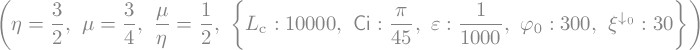

In [4]:
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
        Ci: pr.model.Ci, 
        Lc: pr.model.Lc, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
#         kappa_h: pr.model.kappa_h,
#         h_0: pr.model.h_0,
#         x_sigma: pr.model.x_sigma,
#         x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [5]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=True,
                  do_geodesic=False, 
                  parameters=sub, 
                  do_raw=False )

In [6]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta'])
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix.replace('.','p')
job_name

'indicatrix_exploration_sinbeta_eta1p5'

# Plots

In [7]:
gr = TheoryPlots()
gr.indicatrix_prep(gmeq, pr, subexp, varphi_=1)

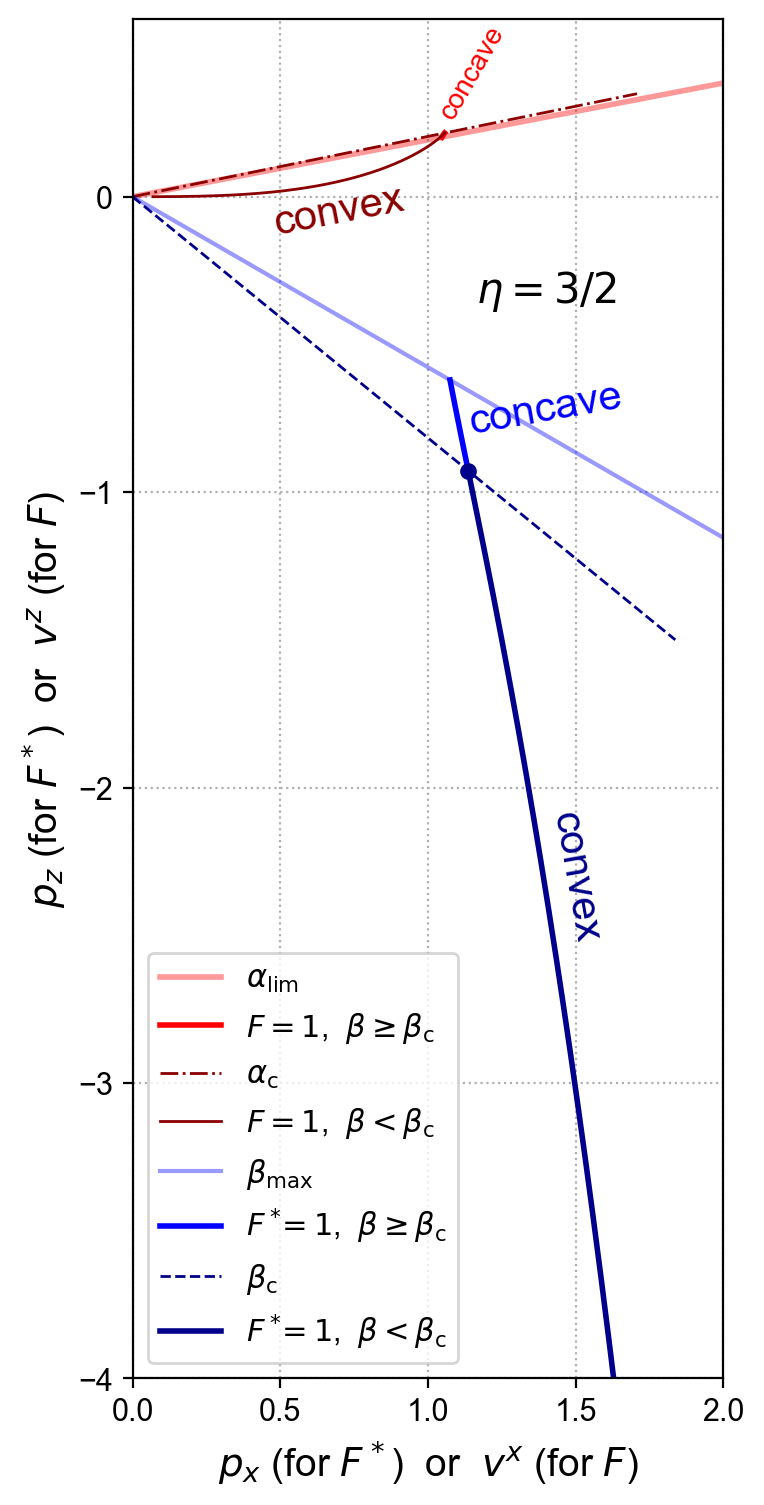

In [8]:
gr.Fstar_F_rectlinear(gmeq, job_name, pr, fig_size=(7,9))

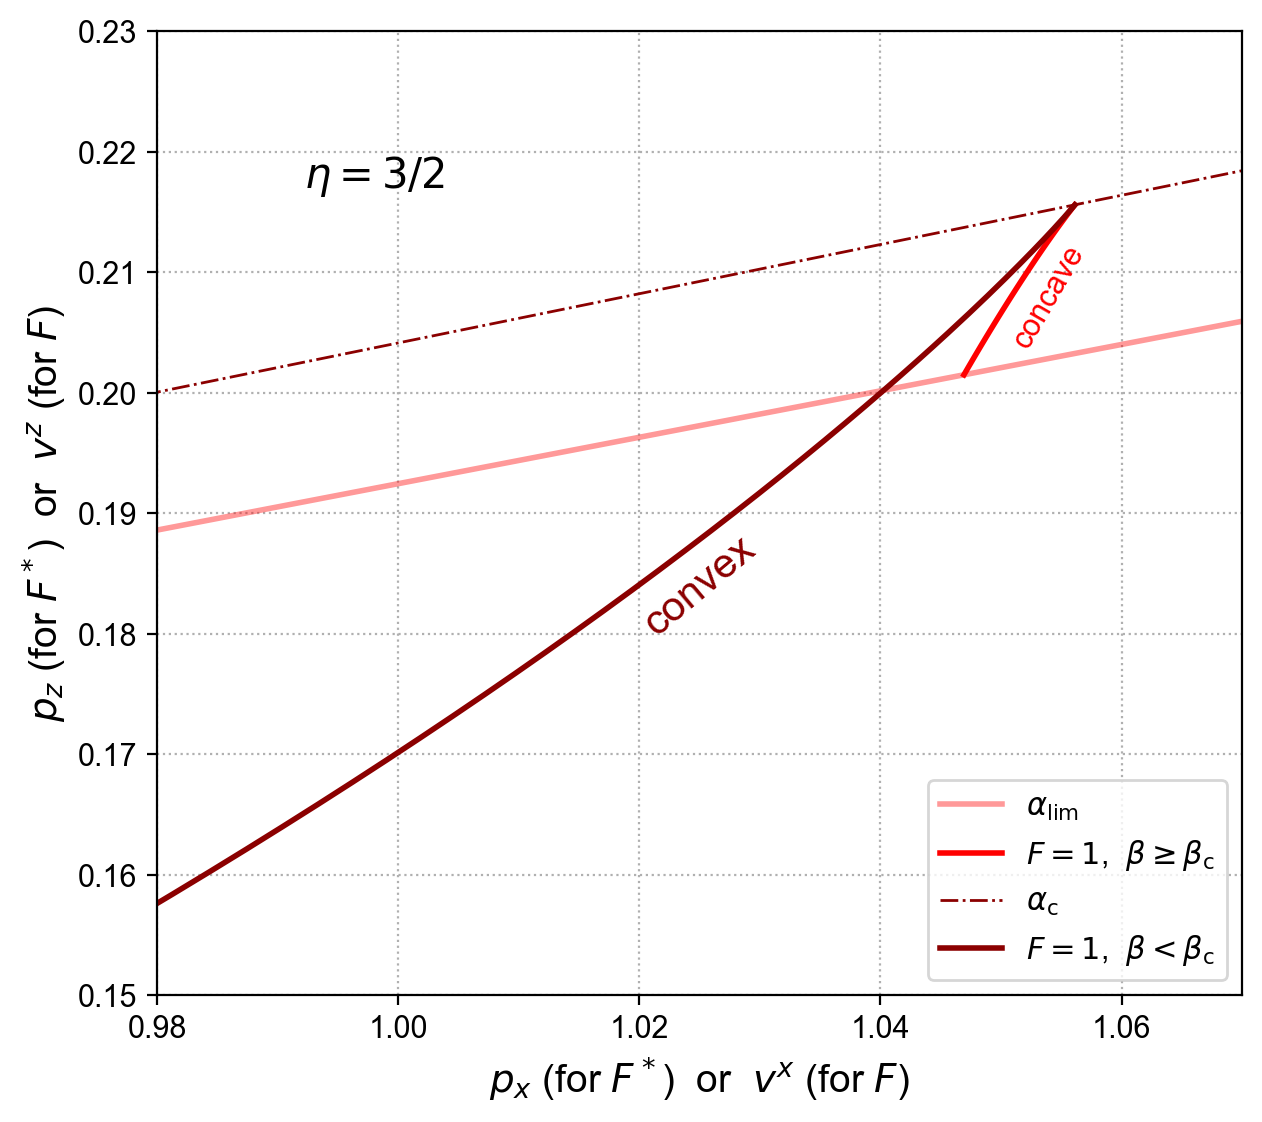

In [13]:
gr.Fstar_F_rectlinear(gmeq, job_name, pr, fig_size=(7,7), do_zoom=True)

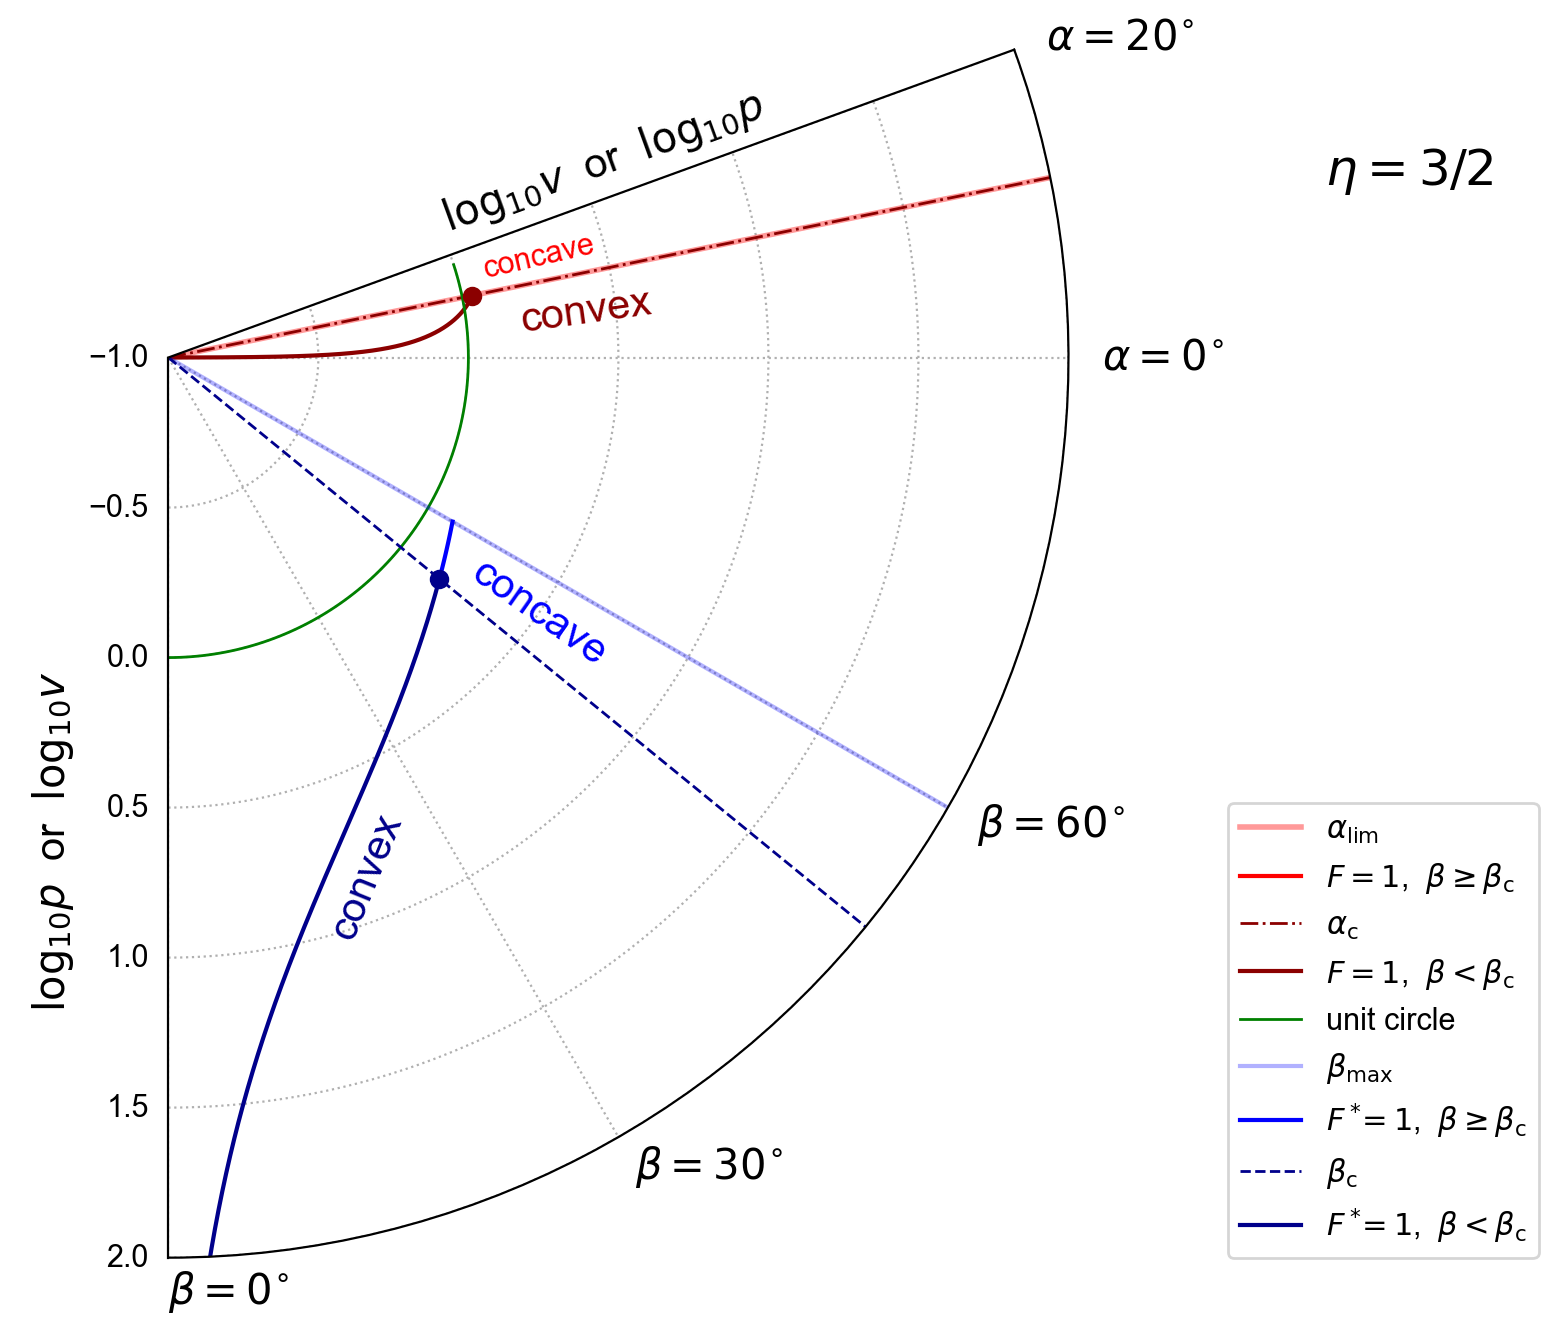

In [14]:
gr.Fstar_F_polar(gmeq, job_name, pr)

# Save

In [15]:
pp(gr.fdict)

{   'indicatrix_exploration_sinbeta_eta1p5_Fstar_F_polar': <Figure size 800x800 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta1p5_Fstar_F_rectlinear': <Figure size 700x900 with 1 Axes>,
    'indicatrix_exploration_sinbeta_eta1p5_Fstar_F_rectlinear_zoom': <Figure size 700x700 with 1 Axes>}


In [16]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "indicatrix_exploration_sinbeta_eta1p5_Fstar_F_rectlinear.png"
Exported "indicatrix_exploration_sinbeta_eta1p5_Fstar_F_rectlinear_zoom.png"
Exported "indicatrix_exploration_sinbeta_eta1p5_Fstar_F_polar.png"
